# 3. Claim frequency and severity regression

We will now predict claim frequency and severity in the MTPL data with a neural network.

In [1]:
# load libs
import os
import numpy as np
import pandas as pd
import graphviz
import random
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import statsmodels.gam.smooth_basis
from statsmodels.gam.api import GLMGam, BSplines
from sklearn.model_selection import train_test_split

seed = 123

def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
reset_random_seeds(seed)

In [2]:
# load data using separator to correctly parse from .txt
df = pd.read_csv(os.path.join(os.getcwd(),"data\PC_data.txt"),  sep=r"\s+")

In [3]:
# column names to smaller case
df.columns = map(str.lower, df.columns)

In [4]:
# rename exp to expo
df.rename(columns={'exp':'expo'}, inplace = True); df.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,2,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,3,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,4,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,5,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [5]:
# train/test split using sklearn
train, test = train_test_split(df, test_size=0.25); print(f'train size:{train.shape}, test size:{test.shape}')

train size:(122423, 18), test size:(40808, 18)


In [6]:
# Reshuffling of the training observations
train = train.sample(frac = 1); print(f'train size:{train.shape}')

train size:(122423, 18)


Claim frequency is usually modelled via GLM with log-link function:

$$
\begin{align}
Y \sim Poisson(\lambda = \exp(x'\beta))
\end{align}
$$

We now redefine this model as a neural network:

<img src="./imgs/glm_vs_nn.jpg" width="440" height="440" align="center"/>

### 3.1 Claim frequency and severity regression

Consider a Poisson GLM model with only an intercept:

$$
\begin{align}
Y \sim Poisson(\lambda = \exp(1\cdot\beta))
\end{align}
$$

Let's fit a neural network with the following parametrization:
* **layer_dense**: there are no hidden layers, the input layer is directly connected to the output layer.
* **units = 1**: there is one output node.
* **activation = 'exponential'**: we use an exponential inverse link function.
* **input_shape = (1,)**: there is one input node, i.e., the intercept which will be constant one.
* **use_bias = FALSE**: we don't need a bias term, since we explicitly include an input node equal to one.
* **loss = 'poisson'**: we maximize the Poisson likelihood, i.e., minimize the Poisson deviance.

In [7]:
reset_random_seeds(seed)

# neural network initialization
nn_freq_intercept = tf.keras.models.Sequential()
nn_freq_intercept.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_intercept.compile(optimizer = 'RMSprop', loss = 'poisson')

**QUESTION:** how many parameters does this model have?

In [8]:
# answer
nn_freq_intercept.count_params()

1

In [9]:
# summary of the structure of the neural netweork
nn_freq_intercept.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [10]:
# create input/output vectors
intercept = np.ones(train.shape[0])
counts = np.array(train['nclaims'])
print(f'size of intercept vector: {intercept.shape[0]}, size of counts vector: {counts.shape[0]}')

size of intercept vector: 122423, size of counts vector: 122423


The **fit()** method shows the following parametrization:
* **x = intercept**: use the intercept as feature.
* **y = counts**: use the claim counts as target.
* **epochs = 20**: perform 20 training iterations over the complete data.
* **batch_size = 1024**: use batches with 1024 observations to update weights.
* **validation_split = 0**: don't use a validation set, so all observations are used for training.
* **verbose = 0**: silence keras such that no output is generated during fitting.


In [11]:
# fit the neural netword
nn_freq_intercept.fit(x = intercept,
                      y = counts,
                      epochs = 30,
                      batch_size = 1024,
                      validation_split = 0,
                      verbose = 0)

We compare the results of our neural network with the same model specified as a GLM:

In [12]:
glm_freq_intercept = sm.formula.glm("nclaims ~ 1", data=train, family=sm.families.Poisson()).fit(); glm_freq_intercept.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122422
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48120.
Date:                Sun, 10 Oct 2021   Deviance:                       67757.
Time:                        01:57:22   Pearson chi2:                 1.33e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0819      0.008   -257.225      0.000      -2.098      -2.066
==============================================================================
"""

In [13]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{np.float(nn_freq_intercept.get_weights()[0])}, \nGLM coefficients:{np.float(glm_freq_intercept.params)}')

NN weights:-2.0769898891448975, 
GLM coefficients:-2.081854127545948


### 5.1.1 Your Turn!

**QUESTION 1:** adapt this code to replicate a **binomial** GLM with a **logit link function**. Add **accuracy** as a metric in your model. Consider the following hint:
* _Hint 1:_ the sigmoid activation function is the inverse of the logit link function.
* _Hint 2:_ the binary_crossentropy loss maximizes the loglikelihood of Bernoulli outcomes:
$$
\begin{align}
\sum^{n}_{i=1}{(y_{i}\cdot log(p_{i})+(1-y_{i})\cdot log(1-p_{i})).}
\end{align}
$$

In [15]:
reset_random_seeds(seed)

# setting up neural network
exercize_nn = tf.keras.models.Sequential()
exercize_nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', input_shape = (1,), use_bias = False))
exercize_nn.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

**QUESTION 2:** fit your neural network.

In [16]:
exercize_nn.fit(x = intercept,
                y = counts > 0, 
                epochs = 40, 
                batch_size = 1024, 
                validation_split = 0, 
                verbose = 0)

**QUESTION 3:** compare your fitted neural network with a GLM.
* _Hint 1:_ to accomodate the fitting of the logistic regression of a categorical vector, we create a binary proxy variable nclaims_proxy with the following characteristics:
    * proxy = 0 when x = 0
    * proxy = 1 when x > 0

In [17]:
train['nclaims_proxy'] = np.where(train['nclaims'] > 0, 1, 0)

In [19]:
exercize_glm = sm.formula.glm("nclaims_proxy ~ 1 + 1", # it must be fitted this way or 0/1 labels get switched
                            data=train, 
                            family=sm.families.Binomial(sm.families.links.logit())).fit();

print(f'NN weights:{np.float(exercize_nn.get_weights()[0])}, \nGLM coefficients:{np.float(exercize_glm.params)}')

NN weights:-2.0633275508880615, 
GLM coefficients:-2.0620717063272846


In [20]:
exercize_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nclaims_proxy   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122422
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43143.
Date:                Sun, 10 Oct 2021   Deviance:                       86286.
Time:                        01:58:11   Pearson chi2:                 1.22e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0621      0.009   -228.278      0.000      -2.080      -2.044
==============================================================================
"""

In [21]:
exercize_glm.predict()

array([0.11283827, 0.11283827, 0.11283827, ..., 0.11283827, 0.11283827,
       0.11283827])

In [22]:
# Q3: compare prediction
np.unique(np.round(exercize_glm.predict(),5))

array([0.11284])

In [23]:
np.unique(np.round(exercize_nn.predict(x = intercept),5))

array([0.11271], dtype=float32)

In [24]:
# we can now delete the proxy variable from the dataset
train = train.drop('nclaims_proxy',1)

In [25]:
print(np.min(train['expo']), np.min(np.log(train['expo'])))

0.0027397260273972603 -5.8998973535824915


### 5.2 Taking exposure into account in a neural network

The Poisson loss function, including exposure, is:
$$
\begin{align}
\mathcal{L}=\sum_{i}{expo_{i}\cdot \lambda_{i}-y_{i}\cdot log(expo_{i}\cdot \lambda_{i})},
\end{align}
$$
which is proportional to:
$$
\begin{align}
\mathcal{L}=\sum_{i}{expo_{i}\cdot (\lambda_{i}-\frac{y_{i}}{expo_{i}}log(\lambda_{i}))}.
\end{align}
$$

This is the loss of a Poisson model with:
* observations $\frac{y_{i}}{expo_{i}}$ and
* weights $expo_{i}$

Notice indeed how the parameter estimates of the following two GLMs are identical.

#### 5.2.1 Fitting GLM with offset component

In [26]:
# GLM with offset
glm_offset = sm.formula.glm("nclaims ~ ageph", 
                            data=train, 
                            offset = np.log(train.expo),
                            family=sm.families.Poisson()).fit(); 
glm_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47566.
Date:                Sun, 10 Oct 2021   Deviance:                       66649.
Time:                        01:58:18   Pearson chi2:                 1.47e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1984      0.026    -45.441      0.000      -1.250      -1.147
ageph         -0.0168      0.001    -29.360      0.000      -0.018      -0.016
==============================================================================
"""

In [27]:
glm_offset.params

Intercept   -1.198433
ageph       -0.016804
dtype: float64

#### 5.2.2 Fitting GLM with weights

In [28]:
# GLM including weights
glm_weights = sm.formula.glm("nclaims ~ ageph", 
                             data=train, 
                             weights = train.expo, 
                             exposure = train.expo, 
                             family=sm.families.Poisson()).fit(); 
glm_weights.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nclaims   No. Observations:               122423
Model:                            GLM   Df Residuals:                   122421
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47566.
Date:                Sun, 10 Oct 2021   Deviance:                       66649.
Time:                        01:58:21   Pearson chi2:                 1.47e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1984      0.026    -45.441      0.000      -1.250      -1.147
ageph         -0.0168      0.001    -29.360      0.000      -0.018      -0.016
==============================================================================
"""

In [29]:
glm_weights.params

Intercept   -1.198433
ageph       -0.016804
dtype: float64

#### 5.2.3 Fitting a neural network with exposure

The specification structure of the neural network remains the same:

In [31]:
reset_random_seeds(seed)

# neural network architecture specification
nn_freq_exposure = tf.keras.models.Sequential()
nn_freq_exposure.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_exposure.compile(optimizer = 'RMSprop', loss = 'poisson')

In [32]:
# create a vector with exposure values
exposure = np.array(train['expo']) # pd.Series must be converted to pd.array due to compatibility reasons with fit() method

In [33]:
# divide claim counts by exposure and use weights
nn_freq_exposure.fit(x = intercept,
                     y = counts/exposure,
                     sample_weight = exposure,
                     epochs = 20,
                     batch_size = 1024,
                     validation_split = 0,
                     verbose = 0)

In [34]:
nn_freq_exposure.get_weights()

[array([[-1.9652466]], dtype=float32)]

In [35]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{nn_freq_exposure.get_weights()[0][0][0]}, \n\nGLM_offset coefficients:{glm_offset.params}, \n\nGLM_weights coefficients:{glm_weights.params}')

NN weights:-1.965246558189392, 

GLM_offset coefficients:Intercept   -1.198433
ageph       -0.016804
dtype: float64, 

GLM_weights coefficients:Intercept   -1.198433
ageph       -0.016804
dtype: float64


### 5.3 How can we include exposure via an offset term?

In [36]:
# create a vector with ageph (pd.Series must be converted to pd.array due to compatibility reasons with fit() method)
ageph = np.array(train['ageph'])

In [38]:
reset_random_seeds(seed)

# neural network architecture specification
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.BatchNormalization(input_shape = (1,))) # layer_batch_normalization centers and scales the input features
nn_freq_ageph.add(tf.keras.layers.Dense(units = 5, activation = 'tanh'))
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) # Notice how we set use_bias = TRUE for the intercept.
nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson')

In [39]:
nn_freq_ageph.fit(ageph,
                 counts/exposure,
                 sample_weight = exposure,
                 epochs = 20,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 0)

In [40]:
nn_freq_ageph.get_weights()

[array([0.7084903], dtype=float32),
 array([0.38735807], dtype=float32),
 array([47.015095], dtype=float32),
 array([219.40018], dtype=float32),
 array([[-0.52467084,  0.14787085, -0.28749973,  0.06453697,  0.4256467 ]],
       dtype=float32),
 array([-0.40032643,  0.3702411 , -0.37861714, -0.36824194, -0.3823439 ],
       dtype=float32),
 array([[ 0.9759775 ],
        [-1.0631176 ],
        [ 0.78664863],
        [ 0.7501453 ],
        [ 0.685709  ]], dtype=float32),
 array([-0.36296386], dtype=float32)]

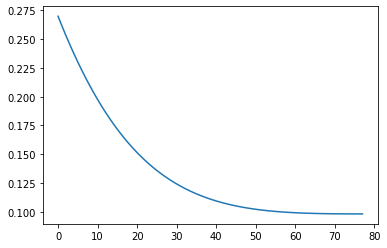

In [41]:
age = tf.cast(np.array(range(18,96)), tf.float32)
nn_pred = nn_freq_ageph.predict(age)
plt.plot(nn_pred)

### Applying GAM models

In [42]:
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as rpyn
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

C:\Users\Lorenzo\anaconda3\envs\dev_env\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [43]:
#If there are errors about missing R packages, run the code below:
r_utils = importr('utils')
#r_utils.install_packages('codetools')
#r_utils.install_packages('mgcv')

# managing dataframe
base = importr('base')
r_gam_lib = importr('mgcv')
r_gam = r_gam_lib.gam

# importing pd.DataFrame
pandas2ri.activate()
r_df = pandas2ri.py2ri(train)
fmla = robjects.Formula('nclaims ~ s(ageph)')
gam_ageph = r_gam(fmla, data = r_df, family = robjects.r("poisson(link = 'log')"), offset = np.log(train['expo']))
#print(robjects.r.names(r_df))

In [44]:
print(robjects.r.coefficients(gam_ageph))
print(robjects.r.deviance(gam_ageph))

(Intercept)  s(ageph).1  s(ageph).2  s(ageph).3  s(ageph).4  s(ageph).5 

 -1.9909787   0.2912933   0.4707224  -0.4328829   0.1947216  -0.1668344 

 s(ageph).6  s(ageph).7  s(ageph).8  s(ageph).9 

 -0.2141428   0.1941883  -0.9292721  -0.3436226 

[1] 66474.85



In [45]:
list_18_95 = pd.DataFrame({'ageph':list(range(18,96)),
                          'expo':np.ones(len(list(range(18,96))))})
age_18_95_df = pandas2ri.py2ri(list_18_95)

In [46]:
# prediction engine
gam_pred = robjects.r.predict(gam_ageph)
gam_pred_train = np.array(gam_pred); gam_pred_train

array([-2.3363294 , -1.92976244, -1.4114677 , ..., -1.96068803,
       -1.94315672, -1.35548243])

In [47]:
min(gam_pred_train)

-2.3440257324136766

In [48]:
# Prediction Engine
list_18_95 = pd.DataFrame({'ageph':list(range(18,96)),
                          'expo':np.ones(len(list(range(18,96))))})
age_18_95_df = pandas2ri.py2ri(list_18_95)
gam_pred = robjects.r.predict(gam_ageph, newdata = age_18_95_df)
gam_pred_age = np.array(gam_pred); gam_pred_age

array([-1.07291983, -1.12948742, -1.18606142, -1.24263002, -1.29914107,
       -1.35548243, -1.4114677 , -1.46682875, -1.52121614, -1.57420769,
       -1.62532502, -1.67405713, -1.71988924, -1.76233485, -1.80096846,
       -1.83545633, -1.8655828 , -1.89126995, -1.912589  , -1.92976244,
       -1.94315672, -1.95326598, -1.96068803, -1.96609442, -1.97019675,
       -1.97371156, -1.97732624, -1.98166808, -1.98727824, -1.99459199,
       -2.00392583, -2.01547179, -2.02929835, -2.04535728, -2.06349523,
       -2.08346859, -2.10496044, -2.12759818, -2.15097082, -2.17464503,
       -2.19817967, -2.22113827, -2.24309979, -2.26366773, -2.28247797,
       -2.29920564, -2.31357132, -2.32534665, -2.33435944, -2.34049796,
       -2.34371422, -2.34402573, -2.34151545, -2.3363294 , -2.32867182,
       -2.31879786, -2.30700372, -2.29361499, -2.27897342, -2.26342318,
       -2.24729723, -2.23090479, -2.21452062, -2.19837682, -2.1826575 ,
       -2.16749652, -2.15297819, -2.1391407 , -2.12598162, -2.11

In [49]:
# NN = as.numeric(predict(nn_freq_ageph, age))

# creating dataframe
df_plot = pd.DataFrame({'ageph':np.array(range(18,96)),
                        'nn_pred':np.array([float(x) for x in list(nn_pred)])})

# Prediction Engine
list_18_95 = pd.DataFrame({'ageph':list(range(18,96)),
                          'expo':np.ones(len(list(range(18,96))))})

age_18_95_df = pandas2ri.py2ri(list_18_95)

gam_pred = robjects.r.predict(gam_ageph, newdata = age_18_95_df)
gam_pred_age = np.exp(np.array(gam_pred)); gam_pred_age # response transformed

df_plot['gam_pred'] = gam_pred_age

In [50]:
df_plot

,ageph,nn_pred,gam_pred
0,18,0.269782,0.342008
1,19,0.261209,0.323199
2,20,0.252947,0.305422
3,21,0.244992,0.288624
4,22,0.237340,0.272766
...,...,...,...
73,91,0.098105,0.126392
74,92,0.098091,0.127723
75,93,0.098081,0.129048
76,94,0.098074,0.130376


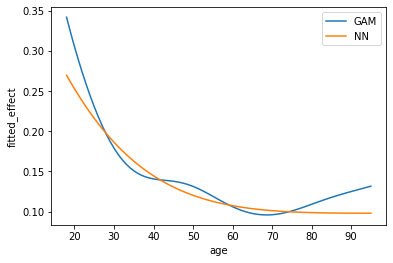

In [51]:
plt.plot(df_plot.ageph, df_plot.gam_pred, label = "GAM")
plt.plot(df_plot.ageph, df_plot.nn_pred, label = "NN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

### Adding a skip connection in a neural network

So far, we stayed in a purely sequential architecture with tf.keras.models.Sequential().Now, we will allow some input nodes to be connected directly to the output node, i.e., skip connections.

<figure>
<img src="./imgs/skip_conn.png" alt="autoencoder_schema" style="width: 300px;"/>
<figcaption><center>Figure taken from <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525">Schelldorfer and Wuthrich (2019)</a>.<p></p></center></figcaption>
</figure>

The output node, without skip connection, calculates:
$$
\begin{align}
f_{activation}{(\sum_{i}w_{i}h_{i}+b)}.
\end{align}
$$

With a skip connection, this simply becomes:
$$
\begin{align}
f_{activation}{(\sum_{i}w_{i}h_{i}+b+s)}.
\end{align}
$$

We take a linear combination of the last hidden layer outputs and add the skip input, before applying the activation function.
So, what can we do with this? Let's take a claim frequency example with the exponential activation function:
* Adding exposure as an offset term:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(expo))} = expo\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$
* Adding a base prediction:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(base))} = base\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$
* The combination of both:
$$
\begin{align}
output = \exp{(\sum_{i}w_{i}h_{i}+b+log(expo\cdot base))} = expo\cdot base\cdot \exp(\sum_{i}w_{i}h_{i}+b)
\end{align}
$$

A skip connection allows us to guide the neural net in the right direction and to model adjustments on top of the base
predictions, for example obtained via a GLM or GAM. In the actuarial lingo this is called a Combined Actuarial Neural Network
(CANN).

In [53]:
reset_random_seeds(seed)

# create two input layers via layer_input, one for the skip connection and one for the neural network
input_nn = tf.keras.layers.Input(shape = (1,), name = 'nn')
input_skip = tf.keras.layers.Input(shape = (1,), name = 'skip')

# specify the architecture to use for the neural net part with a linear combination of the hidden nodes as output
norm_nn = tf.keras.layers.BatchNormalization()(input_nn)
dense_1 = tf.keras.layers.Dense(units = 5, activation = 'tanh')(norm_nn)
network = tf.keras.layers.Dense(units = 1, activation = 'linear')(dense_1)

# combine the neural network and skip connection via layer_add and pass through the exponential function with fixed weights
interm = tf.keras.layers.Add()([network, input_skip])

# output layer
init = tf.constant_initializer(np.ones((1,1)))
output = tf.keras.layers.Dense(units = 1, 
                               activation = 'exponential', 
                               trainable = False,
                               kernel_initializer = init,
                               name = 'output')(interm)

In [54]:
# Define the full model with inputs and output via keras_model and compile as usual
cann = tf.keras.models.Model(inputs = [input_nn, input_skip], outputs = output)
cann.compile(optimizer = 'RMSprop', loss = 'poisson')

Tensorflow is endowed with a specific utility to visualize the structure of the network. We can indeed see the skip connection via layer_add:

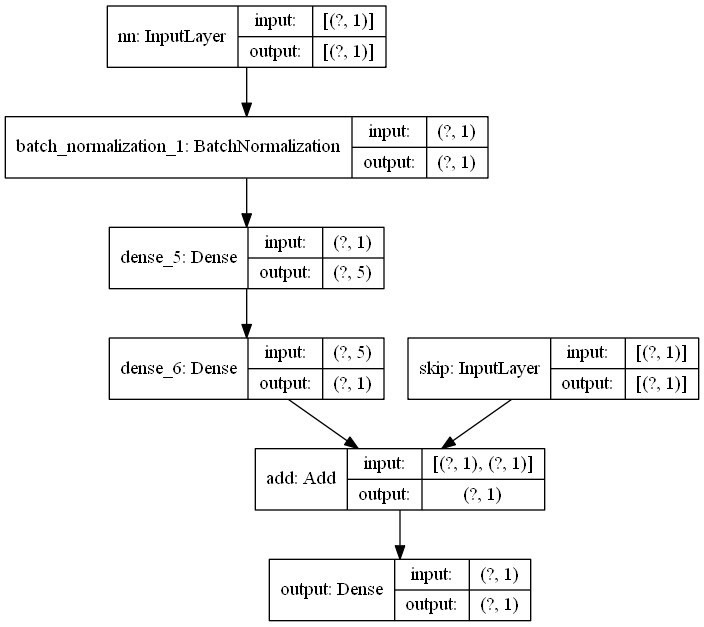

In [55]:
# model structure
tf.keras.utils.plot_model(model=cann, show_shapes=True, to_file='./imgs/model.png')

Calculate the GAM base predictions, including exposure:

In [56]:
gam_expo = np.array(robjects.r.predict(gam_ageph)) + np.log(train['expo']); print(min(gam_expo), max(gam_expo))

-8.243923085996169 -1.0729198349763105


Collect the CANN input data in a named list:

In [57]:
#cann_input = {'nn':np.array(train['ageph']), 'skip':np.array(gam_expo)}
cann_input = [np.array(train['ageph']), gam_expo]

Fit the CANN like we have seen before:

In [58]:
cann.fit(x = [np.array(train['ageph']), gam_expo],
         y = counts,
         epochs = 20,
         batch_size = 1024,
         validation_split = 0,
         verbose = 0)

In [59]:
cann.predict([np.array(train['ageph']), gam_expo])

array([[0.09804892],
       [0.14514801],
       [0.24221306],
       ...,
       [0.14093602],
       [0.14328726],
       [0.19009943]], dtype=float32)

In [60]:
age = np.array(list(range(18,96)))
skip_zeros = np.zeros(age.shape[0])
age_skip_0 = pd.DataFrame({'ageph':age,
                           'skip':skip_zeros})
age_skip_0['cann'] = cann.predict(x={'nn':age_skip_0['ageph'], 'skip':age_skip_0['skip']})

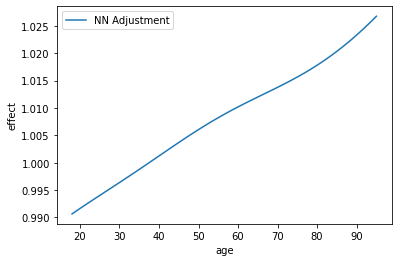

In [61]:
plt.plot(age_skip_0.ageph, age_skip_0.cann, label = "NN Adjustment")
plt.xlabel('age')
plt.ylabel('effect')
plt.legend()
plt.show()

In [62]:
robjects.r.predict(gam_ageph, newdata = age_18_95_df)

-1.072920,-1.129487,-1.186061,-1.242630,...,-2.057895,-2.047571,-2.037329,-2.027119


In [63]:
df = pd.DataFrame({'ageph':np.array(range(18,96)),
                   'skip': robjects.r.predict(gam_ageph, newdata = age_18_95_df)})
df['cann'] = cann.predict([tf.cast(df.ageph,dtype = tf.float32), tf.cast(df.skip,dtype = tf.float32)]); df.head()

,ageph,skip,cann
0,18,-1.072920,0.338810
1,19,-1.129487,0.320337
2,20,-1.186061,0.302867
3,21,-1.242630,0.286350
4,22,-1.299141,0.270748


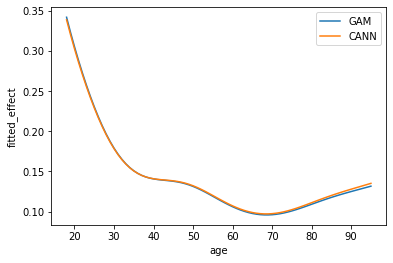

In [64]:
plt.plot(age, np.exp(df.skip), label = "GAM")
plt.plot(age, df.cann, label = "CANN")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()

### Claim severity modeling with neural nets

In [65]:
df_claims = train[train.nclaims > 0]; df_claims.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
142893,142894,1,131.978513,131.978513,1.000000,TPL,gasoline,private,N,male,31,0,12,44,8840,STADEN,3.007460,50.954118
114497,114498,1,173.971676,173.971676,0.580822,PO,gasoline,private,N,male,37,0,6,85,7140,MORLANWE,4.224269,50.457262
61503,61504,1,1400.127417,1400.127417,1.000000,TPL,gasoline,private,N,male,50,5,11,40,4040,HERSTAL,5.612566,50.680020
160888,160889,1,60.138969,60.138969,1.000000,TPL,diesel,private,N,male,25,9,6,47,9840,DE-PINTE,3.657129,50.986503
157278,157279,1,1363.414386,1363.414386,1.000000,TPL,diesel,private,N,male,42,0,14,54,9550,HERZELE,3.879313,50.865075


In [66]:
df_claims.shape

(13814, 18)

Let's model the log severity with a MSE loss:

In [70]:
reset_random_seeds(seed)

# setting up neural network
nn_sev_log = tf.keras.models.Sequential()
nn_sev_log.add(tf.keras.layers.Dense(units = 1, activation = 'linear', input_shape = (1,), use_bias = False))
nn_sev_log.compile(optimizer = 'RMSprop', loss = 'mse')
nn_sev_log.fit(x = np.ones(df_claims.shape[0]),
              y = np.log(np.array(df_claims['avg'])),
              epochs = 100,
              batch_size = 128,
              validation_split = 0,
              verbose = 1)

Train on 13814 samples
Epoch 1/100
13814/13814 [==============================] - 0s 24us/sample - loss: 56.2492
Epoch 2/100
13814/13814 [==============================] - 0s 7us/sample - loss: 54.6665
Epoch 3/100
13814/13814 [==============================] - 0s 7us/sample - loss: 53.1150
Epoch 4/100
13814/13814 [==============================] - 0s 7us/sample - loss: 51.5871
Epoch 5/100
13814/13814 [==============================] - 0s 7us/sample - loss: 50.0833
Epoch 6/100
13814/13814 [==============================] - 0s 7us/sample - loss: 48.6018
Epoch 7/100
13814/13814 [==============================] - 0s 7us/sample - loss: 47.1447
Epoch 8/100
13814/13814 [==============================] - 0s 7us/sample - loss: 45.71020s - loss: 46.30
Epoch 9/100
13814/13814 [==============================] - 0s 7us/sample - loss: 44.2982
Epoch 10/100
13814/13814 [==============================] - 0s 7us/sample - loss: 42.9094
Epoch 11/100
13814/13814 [==============================] - 0s 7us/sa

13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 92/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1772
Epoch 93/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 94/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 95/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1772
Epoch 96/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 97/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 98/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 99/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771
Epoch 100/100
13814/13814 [==============================] - 0s 8us/sample - loss: 2.1771


In [71]:
np.float(np.exp(nn_sev_log.predict(tf.cast([1], dtype = tf.float32))))

455.9310607910156

In [72]:
df_claims['avg'].describe()

count    1.381400e+04
mean     1.692664e+03
std      1.911197e+04
min      2.478935e-02
25%      1.425884e+02
50%      5.305417e+02
75%      1.426379e+03
max      1.989568e+06
Name: avg, dtype: float64

In [75]:
def k_gamma(y_true, y_pred):
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)
    return ((y_true - y_pred) / y_pred) - tf.math.log(y_true / y_pred)

In [76]:
nn_sev_gamma = tf.keras.models.Sequential()
nn_sev_gamma.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_sev_gamma.compile(optimizer = 'RMSprop', loss = k_gamma)
nn_sev_gamma.fit(x = np.ones(df_claims.shape[0]),
                 y = np.array(df_claims['avg']),
                 epochs = 100,
                 batch_size = 128,
                 validation_split = 0)

Train on 13814 samples
Epoch 1/100
13814/13814 [==============================] - 0s 24us/sample - loss: 412.4694
Epoch 2/100
13814/13814 [==============================] - 0s 7us/sample - loss: 377.9580
Epoch 3/100
13814/13814 [==============================] - 0s 8us/sample - loss: 348.1136
Epoch 4/100
13814/13814 [==============================] - 0s 8us/sample - loss: 319.5019
Epoch 5/100
13814/13814 [==============================] - 0s 18us/sample - loss: 292.2634
Epoch 6/100
13814/13814 [==============================] - 0s 9us/sample - loss: 267.9239
Epoch 7/100
13814/13814 [==============================] - 0s 7us/sample - loss: 246.1168
Epoch 8/100
13814/13814 [==============================] - 0s 7us/sample - loss: 225.6197
Epoch 9/100
13814/13814 [==============================] - 0s 7us/sample - loss: 205.9041
Epoch 10/100
13814/13814 [==============================] - 0s 7us/sample - loss: 187.4939
Epoch 11/100
13814/13814 [==============================] - 0s 7us/sample 

13814/13814 [==============================] - 0s 10us/sample - loss: 1.3219
Epoch 92/100
13814/13814 [==============================] - 0s 10us/sample - loss: 1.3215
Epoch 93/100
13814/13814 [==============================] - 0s 8us/sample - loss: 1.3212
Epoch 94/100
13814/13814 [==============================] - 0s 10us/sample - loss: 1.3207
Epoch 95/100
13814/13814 [==============================] - 0s 9us/sample - loss: 1.3204
Epoch 96/100
13814/13814 [==============================] - 0s 10us/sample - loss: 1.3200
Epoch 97/100
13814/13814 [==============================] - 0s 9us/sample - loss: 1.3207
Epoch 98/100
13814/13814 [==============================] - 0s 11us/sample - loss: 1.3211
Epoch 99/100
13814/13814 [==============================] - 0s 10us/sample - loss: 1.3208
Epoch 100/100
13814/13814 [==============================] - 0s 14us/sample - loss: 1.3208


In [77]:
np.float(nn_sev_gamma.predict(tf.cast([1], dtype = tf.float32)))

1516.626220703125

In [80]:
np.mean(df_claims[df_claims['avg'] < 300000]['avg'])

1460.507183587863